# 1. Install Dependencies and Setup

In [5]:
!pip install tensorflow  opencv-python matplotlib

In [6]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.12
albumentations                   1.4.11
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.7.22.0.34.13
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                

In [7]:
import tensorflow as tf
import os

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [10]:
import cv2
import imghdr

In [12]:
data_dir = '/content/drive/MyDrive/images-h'

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [15]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/drive/MyDrive/images-h/train_images/bacterial_leaf_streak
Issue with image /content/drive/MyDrive/images-h/train_images/bacterial_panicle_blight
Issue with image /content/drive/MyDrive/images-h/train_images/bacterial_leaf_blight
Issue with image /content/drive/MyDrive/images-h/train_images/brown_spot
Issue with image /content/drive/MyDrive/images-h/validation_images/validation-images


# 3. Load Data

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [17]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/images-h')

Found 2560 files belonging to 3 classes.


In [18]:
data_iterator = data.as_numpy_iterator()

In [19]:
batch = data_iterator.next()

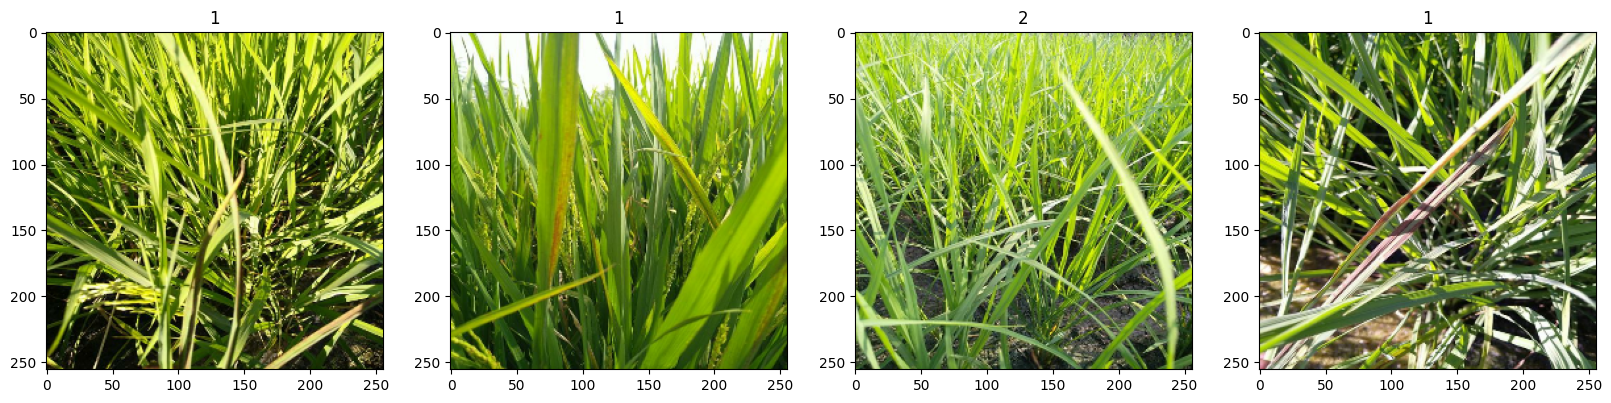

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [21]:
data = data.map(lambda x,y: (x/255, y))

In [22]:
data.as_numpy_iterator().next()

(array([[[[3.44669104e-01, 4.63296562e-01, 1.96691174e-02],
          [4.52328444e-01, 5.81801474e-01, 1.39767155e-01],
          [2.01776966e-01, 3.23345602e-01, 8.27205926e-03],
          ...,
          [4.33333337e-01, 5.47058821e-01, 1.92156866e-01],
          [6.42708361e-01, 7.55514681e-01, 4.03370112e-01],
          [7.45894611e-01, 8.59620094e-01, 5.00428915e-01]],
 
         [[3.65686268e-01, 4.62928921e-01, 1.39154404e-01],
          [3.32352936e-01, 4.36335772e-01, 9.35048983e-02],
          [2.86642164e-01, 4.04289216e-01, 6.02941178e-02],
          ...,
          [5.48284292e-01, 6.60049021e-01, 3.70833337e-01],
          [7.09681392e-01, 8.21446061e-01, 5.26838243e-01],
          [7.64276981e-01, 8.76041651e-01, 5.78982830e-01]],
 
         [[1.68872550e-01, 2.59375006e-01, 1.28676472e-02],
          [3.89767170e-01, 4.77573544e-01, 1.91299021e-01],
          [3.53676468e-01, 4.52941179e-01, 1.51102945e-01],
          ...,
          [6.49816155e-01, 7.69424021e-01, 5.0765

# 5. Split Data

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [24]:
train_size

56

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [26]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [28]:
model = Sequential()

In [29]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [32]:
logdir='logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
56/56 [==============================] - 688s 12s/step - loss: 0.2644 - accuracy: 0.8605 - val_loss: 0.1815 - val_accuracy: 0.8594
Epoch 2/10
56/56 [==============================] - 135s 2s/step - loss: 0.2427 - accuracy: 0.8566 - val_loss: 0.1573 - val_accuracy: 0.8496
Epoch 3/10
56/56 [==============================] - 152s 3s/step - loss: 0.2347 - accuracy: 0.8588 - val_loss: 0.2427 - val_accuracy: 0.8496
Epoch 4/10
56/56 [==============================] - 138s 2s/step - loss: 0.2404 - accuracy: 0.8605 - val_loss: 0.1637 - val_accuracy: 0.8535
Epoch 5/10
56/56 [==============================] - 131s 2s/step - loss: 0.2281 - accuracy: 0.8588 - val_loss: 0.2037 - val_accuracy: 0.8379
Epoch 6/10
56/56 [==============================] - 133s 2s/step - loss: 0.2393 - accuracy: 0.8605 - val_loss: 0.1323 - val_accuracy: 0.8594
Epoch 7/10
56/56 [==============================] - 129s 2s/step - loss: 0.2365 - accuracy: 0.8616 - val_loss: 0.2258 - val_accuracy: 0.8398
Epoch 8/10
5

# 8. Plot Performance

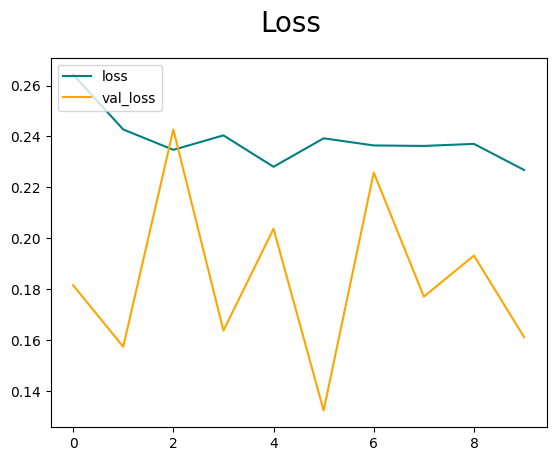

In [35]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

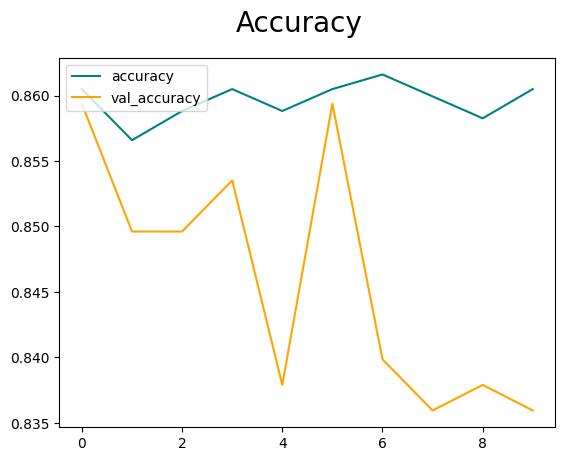

In [36]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [37]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [38]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [39]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 488ms/step


In [40]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.87890625, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.85546875, shape=(), dtype=float32)


# 10. Test

In [41]:
import cv2

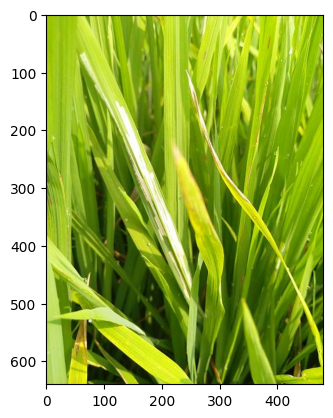

In [42]:
from matplotlib import image as mpimg
from matplotlib import pyplot as plt
img = mpimg.imread('/content/drive/MyDrive/images-h/validation_images/validation-images/200298.jpg')
plt.imshow(img)
plt.show()

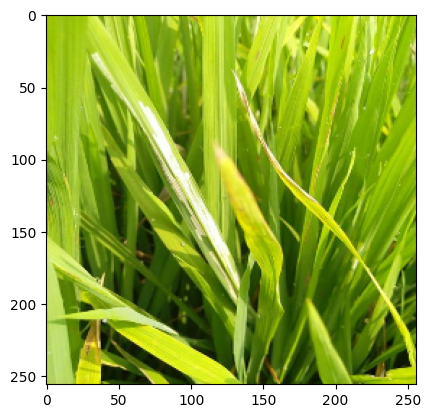

In [43]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [44]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 114ms/step


In [45]:
yhat

array([[0.91801006]], dtype=float32)

In [46]:
if yhat < 0.5:
    print(f'Predicted class is Immature')
    print(yhat*100)

else:
    print(f'Predicted class is Mature')
    print(yhat*100)


Predicted class is Mature
[[91.801]]


# 11. Save the Model

In [47]:
from tensorflow.keras.models import load_model

In [48]:
model.save(os.path.join('models','imageclassifier.h5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [49]:
os.path.join('models','imageclassifier.h5')

'models/imageclassifier.h5'

In [50]:
new_model = load_model(os.path.join('models','imageclassifier.h5'))

In [51]:
new_model

In [52]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 204ms/step


array([[0.91801006]], dtype=float32)